In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
from data import galsim
%pylab inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, 'pixel-cnn/')

/home/francois/.local/lib/python3.7/site-packages/coord/__init__.py:47: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/francois/.local/lib/python3.7/site-packages/coord/include/Angle_C.h' mode='r' encoding='UTF-8'>
  _ffi.cdef(open(file_name).read())


Populating the interactive namespace from numpy and matplotlib


In [4]:
pixel_scale   = 0.11      # native WFIRST resolution
effective_psf_fwhm = 0.14 # Standardized Gaussian FWHM used in morphology model
stamp_size = 32 # Size for postage stamps

In [5]:
data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
batch_size=32

# Let's build an input function for the model
input_fn = galsim.build_input_pipeline(data_dir,
                                        batch_size=batch_size,
                                        stamp_size=stamp_size,
                                        gaussian_fwhm=effective_psf_fwhm,
                                        pixel_size=pixel_scale,
                                        input_nprocs=12, 
                                        clip=10.,
                                        nrepeat=10,
                                        cache_dir='/data2/COSMOS/cache32_10_wfirst')

In [6]:
# Build a pixelCNN Estimator
from pixel_cnn_pp.model import model_spec

In [7]:
def pack_images(images, rows, cols):
    """Helper utility to make a field of images."""
    shape = tf.shape(images)
    width = shape[-3]
    height = shape[-2]
    depth = shape[-1]
    images = tf.reshape(images, (-1, width, height, depth))
    batch = tf.shape(images)[0]
    rows = tf.minimum(rows, batch)
    cols = tf.minimum(batch // rows, cols)
    images = images[:rows * cols]
    images = tf.reshape(images, (rows, cols, width, height, depth))
    images = tf.transpose(images, [0, 2, 1, 3, 4])
    images = tf.reshape(images, [1, rows * width, cols * height, depth])
    return images


def image_tile_summary(name, tensor, rows=8, cols=8):
    tf.summary.image(name, pack_images(tensor, rows, cols), max_outputs=1)

In [8]:
n_channels=1
image_size=stamp_size

def pixelcnn_model_fn(features, labels, mode, params, config):
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    # Extract input images
    x = features['x']
    
    model_opt = { 'nr_resnet': 2, 'nr_filters': 64, 'nr_logistic_mix': 1, 'resnet_nonlinearity': 'concat_elu', 'energy_distance': False}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        # Build the model
        def make_model_spec():
            input_layer = tf.placeholder(tf.float32, shape=[1,image_size, image_size,1])
            model = tf.make_template('model', model_spec)
            out = model(input_layer, None, ema=None, dropout_p=0., **model_opt)
            out = tf.layers.dense(out, 2, activation=None) # project the output to only 2 values
            loc, scale = tf.split(out, num_or_size_splits=2,axis=-1)
            scale = tf.nn.softplus(scale) + 1e-4
            distribution = tfp.distributions.Independent( tfp.distributions.Normal(loc=loc, scale=scale))
            log_prob = - distribution.log_prob(input_layer)
            grads = tf.gradients(log_prob[0], input_layer)
            samples = distribution.sample()
            hub.add_signature(inputs=input_layer,
                              outputs={'grads':grads[0], 'sample':samples,'log_prob':log_prob})
        
        spec = hub.create_module_spec(make_model_spec, drop_collections=['checkpoints'])
        pixelcnn = hub.Module(spec, name="pixelcnn_module")
            
        hub.register_module_for_export(pixelcnn, "pixelcnn_out")
        predictions =  pixelcnn(x, as_dict=True)
        return tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=predictions)
    
    # Build the model
    def make_model_spec():
        input_layer = tf.placeholder(tf.float32, shape=[batch_size, image_size, image_size, n_channels])
        
        model = tf.make_template('model', model_spec)
        out = model(input_layer, None, ema=None, dropout_p=0.5, **model_opt)
        out = tf.layers.dense(out, 2, activation=None) # project the output to only 2 values
        loc, scale = tf.split(out, num_or_size_splits=2,axis=-1)
        scale = tf.nn.softplus(scale) + 1e-4
        # Build Gaussian model for output value
        distribution = tfp.distributions.Independent( tfp.distributions.Normal(loc=loc, scale=scale))
        sample = distribution.sample()
        log_prob = distribution.log_prob(input_layer)
        hub.add_signature(inputs=input_layer,
                          outputs={'sample': sample, 'log_prob': log_prob})

    spec = hub.create_module_spec(make_model_spec, drop_collections=['checkpoints'])
    pixelcnn = hub.Module(spec, name="pixelcnn_module", trainable=True)

    output = pixelcnn(x, as_dict=True)

    loglikelihood = output['log_prob']
    sample = output['sample']
    
    tf.summary.scalar('loglikelihood', tf.reduce_mean(loglikelihood))

    image_tile_summary("image", tf.to_float(x[:16]), rows=4, cols=4)
    image_tile_summary("recon", tf.to_float(sample[:16]), rows=4, cols=4)

    loss = -tf.reduce_mean(loglikelihood)

    # Training of the model
    global_step = tf.train.get_or_create_global_step()
    learning_rate = tf.train.cosine_decay(params["learning_rate"], global_step,
                                          params["max_steps"])
    tf.summary.scalar("learning_rate", learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss , global_step=global_step)

    eval_metric_ops = {"loglikelihood": tf.metrics.mean(tf.reduce_mean(loglikelihood))}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

In [12]:
params={'learning_rate':0.00002, 'max_steps':400000}

In [13]:
mymodel = tf.estimator.Estimator(model_fn=pixelcnn_model_fn,
                                params=params, model_dir='/data2/scarlet/cosmos_pixel_cnn_wfirst_32')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data2/scarlet/cosmos_pixel_cnn_wfirst_32', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f67c5dfac18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
mymodel.train(input_fn, steps=300000)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/scarlet/cosmos_pixel_cnn_wfirst_32/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 100000 into /data2/scarlet/cosmos_pixel_cnn_wfirst_32/model.ckpt.
INFO:tensorflow:loss = -1800.9583, step = 100000
INFO:tensorflow:global_step/sec: 6.63879
INFO:tensorflow:loss = -1764.4392, step = 100100 (15.065 sec)
INFO:tensorflow:global_step/sec: 8.85905
INFO:tensorflow:loss = -1770.6549, step = 100200 (11.288 sec)
INFO:tensorflow:global_step/sec: 8.83233
INFO:tensorflow:loss = -1812.7471, step = 100300 (11.322 sec)
INFO:tensorflow:global_step/sec: 8.8366
INFO:tensorflow:loss = -1733.5748, step = 100400 (11.316 sec)
INFO:tensorflow:global_step/sec: 8.80062


INFO:tensorflow:global_step/sec: 8.71973
INFO:tensorflow:loss = -1761.7141, step = 107500 (11.469 sec)
INFO:tensorflow:global_step/sec: 8.58296
INFO:tensorflow:loss = -1741.9338, step = 107600 (11.652 sec)
INFO:tensorflow:global_step/sec: 8.62893
INFO:tensorflow:loss = -1750.178, step = 107700 (11.588 sec)
INFO:tensorflow:global_step/sec: 8.56717
INFO:tensorflow:loss = -1786.936, step = 107800 (11.672 sec)
INFO:tensorflow:global_step/sec: 8.65447
INFO:tensorflow:loss = -1769.2719, step = 107900 (11.555 sec)
INFO:tensorflow:global_step/sec: 8.60253
INFO:tensorflow:loss = -1766.0114, step = 108000 (11.624 sec)
INFO:tensorflow:global_step/sec: 8.66869
INFO:tensorflow:loss = -1770.7998, step = 108100 (11.535 sec)
INFO:tensorflow:global_step/sec: 8.70739
INFO:tensorflow:loss = -1806.6055, step = 108200 (11.485 sec)
INFO:tensorflow:global_step/sec: 8.54444
INFO:tensorflow:loss = -1767.7394, step = 108300 (11.703 sec)
INFO:tensorflow:global_step/sec: 8.67416
INFO:tensorflow:loss = -1817.3557,

INFO:tensorflow:global_step/sec: 8.75041
INFO:tensorflow:loss = -1758.5952, step = 115400 (11.428 sec)
INFO:tensorflow:Saving checkpoints for 115493 into /data2/scarlet/cosmos_pixel_cnn_wfirst_32/model.ckpt.
INFO:tensorflow:global_step/sec: 7.91802
INFO:tensorflow:loss = -1812.3627, step = 115500 (12.629 sec)
INFO:tensorflow:global_step/sec: 8.73754
INFO:tensorflow:loss = -1856.821, step = 115600 (11.444 sec)
INFO:tensorflow:global_step/sec: 8.67443
INFO:tensorflow:loss = -1759.113, step = 115700 (11.531 sec)
INFO:tensorflow:global_step/sec: 8.68782
INFO:tensorflow:loss = -1716.4847, step = 115800 (11.508 sec)
INFO:tensorflow:global_step/sec: 8.72667
INFO:tensorflow:loss = -1740.1411, step = 115900 (11.459 sec)
INFO:tensorflow:global_step/sec: 8.6307
INFO:tensorflow:loss = -1768.7637, step = 116000 (11.587 sec)
INFO:tensorflow:global_step/sec: 8.6547
INFO:tensorflow:loss = -1772.7476, step = 116100 (11.554 sec)
INFO:tensorflow:global_step/sec: 8.67858
INFO:tensorflow:loss = -1755.4325,

INFO:tensorflow:global_step/sec: 8.71584
INFO:tensorflow:loss = -1753.7434, step = 123200 (11.473 sec)
INFO:tensorflow:global_step/sec: 8.65025
INFO:tensorflow:loss = -1751.1672, step = 123300 (11.560 sec)
INFO:tensorflow:global_step/sec: 8.69497
INFO:tensorflow:loss = -1809.941, step = 123400 (11.501 sec)
INFO:tensorflow:global_step/sec: 8.71742
INFO:tensorflow:loss = -1793.2947, step = 123500 (11.472 sec)
INFO:tensorflow:global_step/sec: 8.63598
INFO:tensorflow:loss = -1782.884, step = 123600 (11.580 sec)
INFO:tensorflow:global_step/sec: 8.79038
INFO:tensorflow:loss = -1755.877, step = 123700 (11.376 sec)
INFO:tensorflow:global_step/sec: 8.67059
INFO:tensorflow:loss = -1737.6138, step = 123800 (11.533 sec)
INFO:tensorflow:global_step/sec: 8.61746
INFO:tensorflow:loss = -1799.9948, step = 123900 (11.605 sec)
INFO:tensorflow:global_step/sec: 8.72614
INFO:tensorflow:loss = -1712.543, step = 124000 (11.460 sec)
INFO:tensorflow:global_step/sec: 8.76413
INFO:tensorflow:loss = -1755.9664, s

INFO:tensorflow:global_step/sec: 8.71918
INFO:tensorflow:loss = -1698.733, step = 131100 (11.469 sec)
INFO:tensorflow:Saving checkpoints for 131126 into /data2/scarlet/cosmos_pixel_cnn_wfirst_32/model.ckpt.
INFO:tensorflow:global_step/sec: 7.95691
INFO:tensorflow:loss = -1761.9866, step = 131200 (12.568 sec)
INFO:tensorflow:global_step/sec: 8.57687
INFO:tensorflow:loss = -1803.4667, step = 131300 (11.659 sec)
INFO:tensorflow:global_step/sec: 8.76196
INFO:tensorflow:loss = -1734.5184, step = 131400 (11.413 sec)
INFO:tensorflow:global_step/sec: 8.75942
INFO:tensorflow:loss = -1795.6069, step = 131500 (11.416 sec)
INFO:tensorflow:global_step/sec: 8.70295
INFO:tensorflow:loss = -1784.0095, step = 131600 (11.491 sec)
INFO:tensorflow:global_step/sec: 8.70372
INFO:tensorflow:loss = -1779.4574, step = 131700 (11.489 sec)
INFO:tensorflow:global_step/sec: 8.74576
INFO:tensorflow:loss = -1726.2534, step = 131800 (11.434 sec)
INFO:tensorflow:global_step/sec: 8.65566
INFO:tensorflow:loss = -1750.05

INFO:tensorflow:global_step/sec: 8.68694
INFO:tensorflow:loss = -1808.3461, step = 138900 (11.511 sec)
INFO:tensorflow:global_step/sec: 8.66657
INFO:tensorflow:loss = -1728.8555, step = 139000 (11.539 sec)
INFO:tensorflow:global_step/sec: 8.73941
INFO:tensorflow:loss = -1782.617, step = 139100 (11.442 sec)
INFO:tensorflow:global_step/sec: 8.77394
INFO:tensorflow:loss = -1751.3354, step = 139200 (11.397 sec)
INFO:tensorflow:global_step/sec: 8.58884
INFO:tensorflow:loss = -1798.8472, step = 139300 (11.643 sec)
INFO:tensorflow:global_step/sec: 8.64267
INFO:tensorflow:loss = -1794.8444, step = 139400 (11.570 sec)
INFO:tensorflow:global_step/sec: 8.71367
INFO:tensorflow:loss = -1738.1624, step = 139500 (11.477 sec)
INFO:tensorflow:global_step/sec: 8.74542
INFO:tensorflow:loss = -1802.9564, step = 139600 (11.435 sec)
INFO:tensorflow:global_step/sec: 8.6771
INFO:tensorflow:loss = -1730.3082, step = 139700 (11.524 sec)
INFO:tensorflow:global_step/sec: 8.73407
INFO:tensorflow:loss = -1733.6669,

INFO:tensorflow:Saving checkpoints for 146752 into /data2/scarlet/cosmos_pixel_cnn_wfirst_32/model.ckpt.
INFO:tensorflow:global_step/sec: 7.89281
INFO:tensorflow:loss = -1718.8367, step = 146800 (12.670 sec)
INFO:tensorflow:global_step/sec: 8.75649
INFO:tensorflow:loss = -1799.7467, step = 146900 (11.420 sec)
INFO:tensorflow:global_step/sec: 8.72927
INFO:tensorflow:loss = -1786.087, step = 147000 (11.456 sec)
INFO:tensorflow:global_step/sec: 8.63436
INFO:tensorflow:loss = -1790.0742, step = 147100 (11.582 sec)
INFO:tensorflow:global_step/sec: 8.75735
INFO:tensorflow:loss = -1787.2399, step = 147200 (11.418 sec)
INFO:tensorflow:global_step/sec: 8.78358
INFO:tensorflow:loss = -1748.0636, step = 147300 (11.385 sec)
INFO:tensorflow:global_step/sec: 8.62903
INFO:tensorflow:loss = -1803.1271, step = 147400 (11.588 sec)
INFO:tensorflow:global_step/sec: 8.65281
INFO:tensorflow:loss = -1847.9463, step = 147500 (11.557 sec)
INFO:tensorflow:global_step/sec: 8.75104
INFO:tensorflow:loss = -1760.60

INFO:tensorflow:global_step/sec: 8.70727
INFO:tensorflow:loss = -1785.1238, step = 154600 (11.484 sec)
INFO:tensorflow:global_step/sec: 8.78804
INFO:tensorflow:loss = -1719.938, step = 154700 (11.379 sec)
INFO:tensorflow:global_step/sec: 8.65955
INFO:tensorflow:loss = -1742.7742, step = 154800 (11.549 sec)
INFO:tensorflow:global_step/sec: 8.67212
INFO:tensorflow:loss = -1758.7534, step = 154900 (11.530 sec)
INFO:tensorflow:global_step/sec: 8.7253
INFO:tensorflow:loss = -1751.6517, step = 155000 (11.461 sec)
INFO:tensorflow:global_step/sec: 8.71697
INFO:tensorflow:loss = -1718.8586, step = 155100 (11.471 sec)
INFO:tensorflow:global_step/sec: 8.77549
INFO:tensorflow:loss = -1812.4363, step = 155200 (11.396 sec)
INFO:tensorflow:global_step/sec: 8.77502
INFO:tensorflow:loss = -1760.0626, step = 155300 (11.396 sec)
INFO:tensorflow:global_step/sec: 8.64787
INFO:tensorflow:loss = -1671.7148, step = 155400 (11.564 sec)
INFO:tensorflow:global_step/sec: 8.68551
INFO:tensorflow:loss = -1769.4894,

INFO:tensorflow:global_step/sec: 7.83821
INFO:tensorflow:loss = -1784.0825, step = 162400 (12.758 sec)
INFO:tensorflow:global_step/sec: 8.81664
INFO:tensorflow:loss = -1800.3907, step = 162500 (11.342 sec)
INFO:tensorflow:global_step/sec: 8.72222
INFO:tensorflow:loss = -1830.4213, step = 162600 (11.465 sec)
INFO:tensorflow:global_step/sec: 8.80753
INFO:tensorflow:loss = -1791.0492, step = 162700 (11.354 sec)
INFO:tensorflow:global_step/sec: 8.63174
INFO:tensorflow:loss = -1800.6467, step = 162800 (11.585 sec)
INFO:tensorflow:global_step/sec: 8.74371
INFO:tensorflow:loss = -1757.3132, step = 162900 (11.438 sec)
INFO:tensorflow:global_step/sec: 8.63411
INFO:tensorflow:loss = -1751.7126, step = 163000 (11.580 sec)
INFO:tensorflow:global_step/sec: 8.72038
INFO:tensorflow:loss = -1719.6105, step = 163100 (11.468 sec)
INFO:tensorflow:global_step/sec: 8.68677
INFO:tensorflow:loss = -1761.5183, step = 163200 (11.512 sec)
INFO:tensorflow:global_step/sec: 8.71946
INFO:tensorflow:loss = -1829.744

INFO:tensorflow:global_step/sec: 8.79407
INFO:tensorflow:loss = -1823.9329, step = 170300 (11.372 sec)
INFO:tensorflow:global_step/sec: 8.73923
INFO:tensorflow:loss = -1791.7524, step = 170400 (11.442 sec)
INFO:tensorflow:global_step/sec: 8.60041
INFO:tensorflow:loss = -1801.3572, step = 170500 (11.627 sec)
INFO:tensorflow:global_step/sec: 8.6122
INFO:tensorflow:loss = -1786.6005, step = 170600 (11.611 sec)
INFO:tensorflow:global_step/sec: 8.65858
INFO:tensorflow:loss = -1804.4976, step = 170700 (11.550 sec)
INFO:tensorflow:global_step/sec: 8.75686
INFO:tensorflow:loss = -1733.3547, step = 170800 (11.419 sec)
INFO:tensorflow:global_step/sec: 8.70982
INFO:tensorflow:loss = -1813.4142, step = 170900 (11.482 sec)
INFO:tensorflow:global_step/sec: 8.74334
INFO:tensorflow:loss = -1759.3552, step = 171000 (11.436 sec)
INFO:tensorflow:global_step/sec: 8.63147
INFO:tensorflow:loss = -1764.603, step = 171100 (11.586 sec)
INFO:tensorflow:global_step/sec: 8.77339
INFO:tensorflow:loss = -1789.8085,

INFO:tensorflow:global_step/sec: 7.98622
INFO:tensorflow:loss = -1809.5271, step = 178100 (12.522 sec)
INFO:tensorflow:global_step/sec: 8.81767
INFO:tensorflow:loss = -1788.1907, step = 178200 (11.341 sec)
INFO:tensorflow:global_step/sec: 8.52394
INFO:tensorflow:loss = -1809.7407, step = 178300 (11.731 sec)
INFO:tensorflow:global_step/sec: 8.67464
INFO:tensorflow:loss = -1731.4966, step = 178400 (11.528 sec)
INFO:tensorflow:global_step/sec: 8.7425
INFO:tensorflow:loss = -1765.4454, step = 178500 (11.438 sec)
INFO:tensorflow:global_step/sec: 8.65626
INFO:tensorflow:loss = -1702.6646, step = 178600 (11.552 sec)
INFO:tensorflow:global_step/sec: 8.78568
INFO:tensorflow:loss = -1766.0723, step = 178700 (11.382 sec)
INFO:tensorflow:global_step/sec: 8.62756
INFO:tensorflow:loss = -1780.3557, step = 178800 (11.591 sec)
INFO:tensorflow:global_step/sec: 8.61674
INFO:tensorflow:loss = -1768.7346, step = 178900 (11.606 sec)
INFO:tensorflow:global_step/sec: 8.72516
INFO:tensorflow:loss = -1761.5249

INFO:tensorflow:global_step/sec: 8.72619
INFO:tensorflow:loss = -1796.8279, step = 186000 (11.459 sec)
INFO:tensorflow:global_step/sec: 8.63582
INFO:tensorflow:loss = -1754.0691, step = 186100 (11.580 sec)
INFO:tensorflow:global_step/sec: 8.6761
INFO:tensorflow:loss = -1786.8828, step = 186200 (11.526 sec)
INFO:tensorflow:global_step/sec: 8.69184
INFO:tensorflow:loss = -1853.77, step = 186300 (11.504 sec)
INFO:tensorflow:global_step/sec: 8.67543
INFO:tensorflow:loss = -1763.4283, step = 186400 (11.527 sec)
INFO:tensorflow:global_step/sec: 8.69596
INFO:tensorflow:loss = -1753.8186, step = 186500 (11.500 sec)
INFO:tensorflow:global_step/sec: 8.74612
INFO:tensorflow:loss = -1784.6797, step = 186600 (11.435 sec)
INFO:tensorflow:global_step/sec: 8.68916
INFO:tensorflow:loss = -1810.7034, step = 186700 (11.508 sec)
INFO:tensorflow:global_step/sec: 8.74107
INFO:tensorflow:loss = -1776.4862, step = 186800 (11.441 sec)
INFO:tensorflow:global_step/sec: 8.61102
INFO:tensorflow:loss = -1776.9564, 

INFO:tensorflow:global_step/sec: 8.69089
INFO:tensorflow:loss = -1793.9062, step = 193800 (11.507 sec)
INFO:tensorflow:global_step/sec: 8.77762
INFO:tensorflow:loss = -1692.5933, step = 193900 (11.393 sec)
INFO:tensorflow:global_step/sec: 8.76995
INFO:tensorflow:loss = -1781.1921, step = 194000 (11.402 sec)
INFO:tensorflow:global_step/sec: 8.62419
INFO:tensorflow:loss = -1756.7557, step = 194100 (11.595 sec)
INFO:tensorflow:global_step/sec: 8.58465
INFO:tensorflow:loss = -1724.6841, step = 194200 (11.649 sec)
INFO:tensorflow:global_step/sec: 8.70466
INFO:tensorflow:loss = -1743.5735, step = 194300 (11.488 sec)
INFO:tensorflow:global_step/sec: 8.76511
INFO:tensorflow:loss = -1809.9583, step = 194400 (11.409 sec)
INFO:tensorflow:global_step/sec: 8.61925
INFO:tensorflow:loss = -1761.7638, step = 194500 (11.602 sec)
INFO:tensorflow:global_step/sec: 8.67821
INFO:tensorflow:loss = -1776.1328, step = 194600 (11.523 sec)
INFO:tensorflow:global_step/sec: 8.67018
INFO:tensorflow:loss = -1758.884

INFO:tensorflow:global_step/sec: 8.72117
INFO:tensorflow:loss = -1775.6672, step = 201700 (11.466 sec)
INFO:tensorflow:global_step/sec: 8.7191
INFO:tensorflow:loss = -1783.9526, step = 201800 (11.469 sec)
INFO:tensorflow:global_step/sec: 8.68389
INFO:tensorflow:loss = -1798.5895, step = 201900 (11.515 sec)
INFO:tensorflow:global_step/sec: 8.67187
INFO:tensorflow:loss = -1799.1018, step = 202000 (11.531 sec)
INFO:tensorflow:global_step/sec: 8.79296
INFO:tensorflow:loss = -1786.449, step = 202100 (11.373 sec)
INFO:tensorflow:global_step/sec: 8.6161
INFO:tensorflow:loss = -1755.926, step = 202200 (11.606 sec)
INFO:tensorflow:global_step/sec: 8.74017
INFO:tensorflow:loss = -1786.2527, step = 202300 (11.441 sec)
INFO:tensorflow:global_step/sec: 8.68715
INFO:tensorflow:loss = -1797.7853, step = 202400 (11.512 sec)
INFO:tensorflow:global_step/sec: 8.69319
INFO:tensorflow:loss = -1805.4666, step = 202500 (11.503 sec)
INFO:tensorflow:global_step/sec: 8.79052
INFO:tensorflow:loss = -1753.0359, s

INFO:tensorflow:global_step/sec: 8.6807
INFO:tensorflow:loss = -1785.6732, step = 209500 (11.520 sec)
INFO:tensorflow:global_step/sec: 8.73472
INFO:tensorflow:loss = -1779.8915, step = 209600 (11.449 sec)
INFO:tensorflow:global_step/sec: 8.78277
INFO:tensorflow:loss = -1784.4554, step = 209700 (11.386 sec)
INFO:tensorflow:global_step/sec: 8.80167
INFO:tensorflow:loss = -1753.9866, step = 209800 (11.362 sec)
INFO:tensorflow:global_step/sec: 8.6377
INFO:tensorflow:loss = -1734.1244, step = 209900 (11.576 sec)
INFO:tensorflow:global_step/sec: 8.68866
INFO:tensorflow:loss = -1780.3811, step = 210000 (11.510 sec)
INFO:tensorflow:global_step/sec: 8.65402
INFO:tensorflow:loss = -1767.1064, step = 210100 (11.555 sec)
INFO:tensorflow:global_step/sec: 8.68174
INFO:tensorflow:loss = -1771.01, step = 210200 (11.519 sec)
INFO:tensorflow:global_step/sec: 8.75834
INFO:tensorflow:loss = -1782.503, step = 210300 (11.417 sec)
INFO:tensorflow:global_step/sec: 8.70501
INFO:tensorflow:loss = -1797.1892, st

INFO:tensorflow:global_step/sec: 8.7439
INFO:tensorflow:loss = -1761.7668, step = 217400 (11.437 sec)
INFO:tensorflow:global_step/sec: 8.73002
INFO:tensorflow:loss = -1676.1445, step = 217500 (11.454 sec)
INFO:tensorflow:global_step/sec: 8.80565
INFO:tensorflow:loss = -1789.5231, step = 217600 (11.357 sec)
INFO:tensorflow:global_step/sec: 8.60778
INFO:tensorflow:loss = -1775.7028, step = 217700 (11.616 sec)
INFO:tensorflow:global_step/sec: 8.71723
INFO:tensorflow:loss = -1760.3057, step = 217800 (11.472 sec)
INFO:tensorflow:global_step/sec: 8.69376
INFO:tensorflow:loss = -1850.3743, step = 217900 (11.502 sec)
INFO:tensorflow:global_step/sec: 8.70977
INFO:tensorflow:loss = -1725.1116, step = 218000 (11.481 sec)
INFO:tensorflow:global_step/sec: 8.65026
INFO:tensorflow:loss = -1790.0366, step = 218100 (11.561 sec)
INFO:tensorflow:global_step/sec: 8.80648
INFO:tensorflow:loss = -1787.4634, step = 218200 (11.355 sec)
INFO:tensorflow:global_step/sec: 8.71195
INFO:tensorflow:loss = -1841.2303

INFO:tensorflow:global_step/sec: 8.77556
INFO:tensorflow:loss = -1774.8335, step = 225200 (11.396 sec)
INFO:tensorflow:global_step/sec: 8.66284
INFO:tensorflow:loss = -1761.2805, step = 225300 (11.543 sec)
INFO:tensorflow:global_step/sec: 8.72166
INFO:tensorflow:loss = -1802.362, step = 225400 (11.466 sec)
INFO:tensorflow:global_step/sec: 8.65649
INFO:tensorflow:loss = -1791.3135, step = 225500 (11.551 sec)
INFO:tensorflow:global_step/sec: 8.70393
INFO:tensorflow:loss = -1759.6177, step = 225600 (11.489 sec)
INFO:tensorflow:global_step/sec: 8.79527
INFO:tensorflow:loss = -1735.2642, step = 225700 (11.370 sec)
INFO:tensorflow:global_step/sec: 8.65725
INFO:tensorflow:loss = -1739.0195, step = 225800 (11.552 sec)
INFO:tensorflow:global_step/sec: 8.56393
INFO:tensorflow:loss = -1836.52, step = 225900 (11.677 sec)
INFO:tensorflow:global_step/sec: 8.66986
INFO:tensorflow:loss = -1740.3176, step = 226000 (11.536 sec)
INFO:tensorflow:global_step/sec: 8.67866
INFO:tensorflow:loss = -1768.6714, 

INFO:tensorflow:global_step/sec: 8.63758
INFO:tensorflow:loss = -1831.8252, step = 233100 (11.578 sec)
INFO:tensorflow:global_step/sec: 8.65151
INFO:tensorflow:loss = -1798.3755, step = 233200 (11.559 sec)
INFO:tensorflow:global_step/sec: 8.76368
INFO:tensorflow:loss = -1723.573, step = 233300 (11.410 sec)
INFO:tensorflow:global_step/sec: 8.73767
INFO:tensorflow:loss = -1776.7596, step = 233400 (11.445 sec)
INFO:tensorflow:global_step/sec: 8.69831
INFO:tensorflow:loss = -1759.8959, step = 233500 (11.496 sec)
INFO:tensorflow:global_step/sec: 8.62842
INFO:tensorflow:loss = -1732.5741, step = 233600 (11.590 sec)
INFO:tensorflow:global_step/sec: 8.70845
INFO:tensorflow:loss = -1777.478, step = 233700 (11.483 sec)
INFO:tensorflow:global_step/sec: 8.74659
INFO:tensorflow:loss = -1813.7625, step = 233800 (11.432 sec)
INFO:tensorflow:global_step/sec: 8.63984
INFO:tensorflow:loss = -1762.9954, step = 233900 (11.575 sec)
INFO:tensorflow:global_step/sec: 8.65175
INFO:tensorflow:loss = -1773.5679,

INFO:tensorflow:global_step/sec: 8.6394
INFO:tensorflow:loss = -1769.5431, step = 240900 (11.575 sec)
INFO:tensorflow:global_step/sec: 8.76692
INFO:tensorflow:loss = -1774.3584, step = 241000 (11.406 sec)
INFO:tensorflow:global_step/sec: 8.68577
INFO:tensorflow:loss = -1817.8335, step = 241100 (11.514 sec)
INFO:tensorflow:global_step/sec: 8.66304
INFO:tensorflow:loss = -1749.9427, step = 241200 (11.543 sec)
INFO:tensorflow:global_step/sec: 8.77713
INFO:tensorflow:loss = -1786.0266, step = 241300 (11.394 sec)
INFO:tensorflow:global_step/sec: 8.71262
INFO:tensorflow:loss = -1803.2234, step = 241400 (11.478 sec)
INFO:tensorflow:global_step/sec: 8.76098
INFO:tensorflow:loss = -1769.8086, step = 241500 (11.414 sec)
INFO:tensorflow:global_step/sec: 8.76757
INFO:tensorflow:loss = -1793.2358, step = 241600 (11.406 sec)
INFO:tensorflow:global_step/sec: 8.71749
INFO:tensorflow:loss = -1760.2566, step = 241700 (11.471 sec)
INFO:tensorflow:global_step/sec: 8.74304
INFO:tensorflow:loss = -1736.887,

INFO:tensorflow:global_step/sec: 8.81378
INFO:tensorflow:loss = -1756.7163, step = 248800 (11.347 sec)
INFO:tensorflow:global_step/sec: 8.55087
INFO:tensorflow:loss = -1825.706, step = 248900 (11.694 sec)
INFO:tensorflow:global_step/sec: 8.77252
INFO:tensorflow:loss = -1850.7789, step = 249000 (11.398 sec)
INFO:tensorflow:global_step/sec: 8.63922
INFO:tensorflow:loss = -1751.7958, step = 249100 (11.576 sec)
INFO:tensorflow:global_step/sec: 8.74652
INFO:tensorflow:loss = -1721.0906, step = 249200 (11.434 sec)
INFO:tensorflow:global_step/sec: 8.66603
INFO:tensorflow:loss = -1815.581, step = 249300 (11.539 sec)
INFO:tensorflow:global_step/sec: 8.73847
INFO:tensorflow:loss = -1820.1172, step = 249400 (11.444 sec)
INFO:tensorflow:global_step/sec: 8.64479
INFO:tensorflow:loss = -1821.8809, step = 249500 (11.567 sec)
INFO:tensorflow:global_step/sec: 8.76929
INFO:tensorflow:loss = -1791.396, step = 249600 (11.403 sec)
INFO:tensorflow:global_step/sec: 8.70783
INFO:tensorflow:loss = -1750.0325, 

INFO:tensorflow:global_step/sec: 8.67354
INFO:tensorflow:loss = -1776.2, step = 256600 (11.529 sec)
INFO:tensorflow:global_step/sec: 8.59603
INFO:tensorflow:loss = -1797.6692, step = 256700 (11.633 sec)
INFO:tensorflow:global_step/sec: 8.74295
INFO:tensorflow:loss = -1741.2854, step = 256800 (11.438 sec)
INFO:tensorflow:global_step/sec: 8.74806
INFO:tensorflow:loss = -1756.4857, step = 256900 (11.431 sec)
INFO:tensorflow:global_step/sec: 8.62022
INFO:tensorflow:loss = -1758.8752, step = 257000 (11.601 sec)
INFO:tensorflow:global_step/sec: 8.74678
INFO:tensorflow:loss = -1730.6523, step = 257100 (11.433 sec)
INFO:tensorflow:global_step/sec: 8.76263
INFO:tensorflow:loss = -1790.5493, step = 257200 (11.412 sec)
INFO:tensorflow:global_step/sec: 8.73231
INFO:tensorflow:loss = -1805.102, step = 257300 (11.452 sec)
INFO:tensorflow:global_step/sec: 8.58656
INFO:tensorflow:loss = -1752.8713, step = 257400 (11.646 sec)
INFO:tensorflow:global_step/sec: 8.75742
INFO:tensorflow:loss = -1770.1237, s

INFO:tensorflow:global_step/sec: 8.60705
INFO:tensorflow:loss = -1752.6597, step = 264500 (11.619 sec)
INFO:tensorflow:global_step/sec: 8.69485
INFO:tensorflow:loss = -1773.5563, step = 264600 (11.500 sec)
INFO:tensorflow:global_step/sec: 8.7675
INFO:tensorflow:loss = -1772.2146, step = 264700 (11.407 sec)
INFO:tensorflow:global_step/sec: 8.69445
INFO:tensorflow:loss = -1726.1318, step = 264800 (11.501 sec)
INFO:tensorflow:global_step/sec: 8.69115
INFO:tensorflow:loss = -1781.0144, step = 264900 (11.507 sec)
INFO:tensorflow:global_step/sec: 8.7089
INFO:tensorflow:loss = -1763.8895, step = 265000 (11.482 sec)
INFO:tensorflow:global_step/sec: 8.71543
INFO:tensorflow:loss = -1709.9951, step = 265100 (11.474 sec)
INFO:tensorflow:global_step/sec: 8.61898
INFO:tensorflow:loss = -1788.218, step = 265200 (11.602 sec)
INFO:tensorflow:global_step/sec: 8.72012
INFO:tensorflow:loss = -1789.4568, step = 265300 (11.468 sec)
INFO:tensorflow:global_step/sec: 8.82895
INFO:tensorflow:loss = -1798.1403, 

INFO:tensorflow:global_step/sec: 8.69869
INFO:tensorflow:loss = -1813.2773, step = 272300 (11.496 sec)
INFO:tensorflow:global_step/sec: 8.66945
INFO:tensorflow:loss = -1746.4303, step = 272400 (11.535 sec)
INFO:tensorflow:global_step/sec: 8.62241
INFO:tensorflow:loss = -1802.511, step = 272500 (11.598 sec)
INFO:tensorflow:global_step/sec: 8.81274
INFO:tensorflow:loss = -1799.3931, step = 272600 (11.347 sec)
INFO:tensorflow:global_step/sec: 8.6997
INFO:tensorflow:loss = -1796.9392, step = 272700 (11.495 sec)
INFO:tensorflow:global_step/sec: 8.77351
INFO:tensorflow:loss = -1791.9629, step = 272800 (11.398 sec)
INFO:tensorflow:global_step/sec: 8.60392
INFO:tensorflow:loss = -1781.1322, step = 272900 (11.622 sec)
INFO:tensorflow:global_step/sec: 8.65331
INFO:tensorflow:loss = -1749.6664, step = 273000 (11.558 sec)
INFO:tensorflow:global_step/sec: 8.72517
INFO:tensorflow:loss = -1821.0903, step = 273100 (11.460 sec)
INFO:tensorflow:global_step/sec: 8.7175
INFO:tensorflow:loss = -1765.2751, 

INFO:tensorflow:global_step/sec: 8.70145
INFO:tensorflow:loss = -1787.5686, step = 280200 (11.493 sec)
INFO:tensorflow:global_step/sec: 8.71416
INFO:tensorflow:loss = -1825.3181, step = 280300 (11.475 sec)
INFO:tensorflow:global_step/sec: 8.81028
INFO:tensorflow:loss = -1842.0374, step = 280400 (11.350 sec)
INFO:tensorflow:global_step/sec: 8.72685
INFO:tensorflow:loss = -1823.154, step = 280500 (11.459 sec)
INFO:tensorflow:global_step/sec: 8.64501
INFO:tensorflow:loss = -1788.9019, step = 280600 (11.567 sec)
INFO:tensorflow:global_step/sec: 8.75223
INFO:tensorflow:loss = -1770.9036, step = 280700 (11.426 sec)
INFO:tensorflow:global_step/sec: 8.72238
INFO:tensorflow:loss = -1825.239, step = 280800 (11.465 sec)
INFO:tensorflow:global_step/sec: 8.7293
INFO:tensorflow:loss = -1809.5677, step = 280900 (11.456 sec)
INFO:tensorflow:global_step/sec: 8.66129
INFO:tensorflow:loss = -1802.1675, step = 281000 (11.546 sec)
INFO:tensorflow:global_step/sec: 8.73944
INFO:tensorflow:loss = -1707.8081, 

INFO:tensorflow:global_step/sec: 8.64365
INFO:tensorflow:loss = -1766.0912, step = 288000 (11.569 sec)
INFO:tensorflow:global_step/sec: 8.70753
INFO:tensorflow:loss = -1711.94, step = 288100 (11.484 sec)
INFO:tensorflow:global_step/sec: 8.68448
INFO:tensorflow:loss = -1741.5618, step = 288200 (11.514 sec)
INFO:tensorflow:global_step/sec: 8.65464
INFO:tensorflow:loss = -1802.7795, step = 288300 (11.555 sec)
INFO:tensorflow:global_step/sec: 8.68136
INFO:tensorflow:loss = -1740.9409, step = 288400 (11.519 sec)
INFO:tensorflow:global_step/sec: 8.70465
INFO:tensorflow:loss = -1785.9242, step = 288500 (11.488 sec)
INFO:tensorflow:global_step/sec: 8.72917
INFO:tensorflow:loss = -1791.2178, step = 288600 (11.456 sec)
INFO:tensorflow:global_step/sec: 8.63584
INFO:tensorflow:loss = -1755.5729, step = 288700 (11.579 sec)
INFO:tensorflow:global_step/sec: 8.72902
INFO:tensorflow:loss = -1776.3384, step = 288800 (11.456 sec)
INFO:tensorflow:global_step/sec: 8.60196
INFO:tensorflow:loss = -1702.3303,

INFO:tensorflow:global_step/sec: 8.74933
INFO:tensorflow:loss = -1795.1362, step = 295900 (11.430 sec)
INFO:tensorflow:global_step/sec: 8.68446
INFO:tensorflow:loss = -1799.9174, step = 296000 (11.515 sec)
INFO:tensorflow:global_step/sec: 8.77411
INFO:tensorflow:loss = -1779.7363, step = 296100 (11.397 sec)
INFO:tensorflow:global_step/sec: 8.782
INFO:tensorflow:loss = -1790.2205, step = 296200 (11.388 sec)
INFO:tensorflow:global_step/sec: 8.71299
INFO:tensorflow:loss = -1749.8357, step = 296300 (11.477 sec)
INFO:tensorflow:global_step/sec: 8.77033
INFO:tensorflow:loss = -1823.8998, step = 296400 (11.401 sec)
INFO:tensorflow:global_step/sec: 8.56496
INFO:tensorflow:loss = -1775.4431, step = 296500 (11.676 sec)
INFO:tensorflow:global_step/sec: 8.70539
INFO:tensorflow:loss = -1811.6814, step = 296600 (11.486 sec)
INFO:tensorflow:global_step/sec: 8.8027
INFO:tensorflow:loss = -1781.9861, step = 296700 (11.361 sec)
INFO:tensorflow:global_step/sec: 8.74446
INFO:tensorflow:loss = -1725.5721, 

INFO:tensorflow:global_step/sec: 8.66661
INFO:tensorflow:loss = -1802.607, step = 303700 (11.539 sec)
INFO:tensorflow:global_step/sec: 8.76468
INFO:tensorflow:loss = -1776.394, step = 303800 (11.409 sec)
INFO:tensorflow:global_step/sec: 8.68373
INFO:tensorflow:loss = -1853.2126, step = 303900 (11.516 sec)
INFO:tensorflow:global_step/sec: 8.62814
INFO:tensorflow:loss = -1835.9744, step = 304000 (11.590 sec)
INFO:tensorflow:global_step/sec: 8.73892
INFO:tensorflow:loss = -1822.2113, step = 304100 (11.443 sec)
INFO:tensorflow:global_step/sec: 8.76375
INFO:tensorflow:loss = -1739.3727, step = 304200 (11.411 sec)
INFO:tensorflow:global_step/sec: 8.83458
INFO:tensorflow:loss = -1764.5814, step = 304300 (11.319 sec)
INFO:tensorflow:global_step/sec: 8.73151
INFO:tensorflow:loss = -1728.3142, step = 304400 (11.452 sec)
INFO:tensorflow:global_step/sec: 8.65255
INFO:tensorflow:loss = -1771.0491, step = 304500 (11.558 sec)
INFO:tensorflow:global_step/sec: 8.80587
INFO:tensorflow:loss = -1788.0317,

INFO:tensorflow:global_step/sec: 8.68541
INFO:tensorflow:loss = -1775.578, step = 311600 (11.514 sec)
INFO:tensorflow:global_step/sec: 8.67116
INFO:tensorflow:loss = -1775.0723, step = 311700 (11.532 sec)
INFO:tensorflow:global_step/sec: 8.73283
INFO:tensorflow:loss = -1755.7126, step = 311800 (11.451 sec)
INFO:tensorflow:global_step/sec: 8.76765
INFO:tensorflow:loss = -1806.791, step = 311900 (11.406 sec)
INFO:tensorflow:global_step/sec: 8.78257
INFO:tensorflow:loss = -1751.5667, step = 312000 (11.386 sec)
INFO:tensorflow:global_step/sec: 8.66535
INFO:tensorflow:loss = -1839.3451, step = 312100 (11.540 sec)
INFO:tensorflow:global_step/sec: 8.67631
INFO:tensorflow:loss = -1804.6636, step = 312200 (11.526 sec)
INFO:tensorflow:global_step/sec: 8.70848
INFO:tensorflow:loss = -1749.0066, step = 312300 (11.484 sec)
INFO:tensorflow:global_step/sec: 8.73786
INFO:tensorflow:loss = -1773.4285, step = 312400 (11.444 sec)
INFO:tensorflow:global_step/sec: 8.68186
INFO:tensorflow:loss = -1702.5737,

INFO:tensorflow:global_step/sec: 8.73094
INFO:tensorflow:loss = -1836.9078, step = 319400 (11.454 sec)
INFO:tensorflow:global_step/sec: 8.72078
INFO:tensorflow:loss = -1796.1582, step = 319500 (11.466 sec)
INFO:tensorflow:global_step/sec: 8.63435
INFO:tensorflow:loss = -1711.9015, step = 319600 (11.582 sec)
INFO:tensorflow:global_step/sec: 8.70664
INFO:tensorflow:loss = -1768.9214, step = 319700 (11.485 sec)
INFO:tensorflow:global_step/sec: 8.66382
INFO:tensorflow:loss = -1844.207, step = 319800 (11.542 sec)
INFO:tensorflow:global_step/sec: 8.71827
INFO:tensorflow:loss = -1753.8379, step = 319900 (11.471 sec)
INFO:tensorflow:global_step/sec: 8.70465
INFO:tensorflow:loss = -1746.6287, step = 320000 (11.488 sec)
INFO:tensorflow:global_step/sec: 8.72864
INFO:tensorflow:loss = -1853.3043, step = 320100 (11.456 sec)
INFO:tensorflow:global_step/sec: 8.76843
INFO:tensorflow:loss = -1829.4092, step = 320200 (11.405 sec)
INFO:tensorflow:global_step/sec: 8.62851
INFO:tensorflow:loss = -1772.1027

INFO:tensorflow:global_step/sec: 8.69106
INFO:tensorflow:loss = -1750.6958, step = 327300 (11.506 sec)
INFO:tensorflow:global_step/sec: 8.6827
INFO:tensorflow:loss = -1830.1128, step = 327400 (11.517 sec)
INFO:tensorflow:global_step/sec: 8.73207
INFO:tensorflow:loss = -1804.5121, step = 327500 (11.453 sec)
INFO:tensorflow:global_step/sec: 8.65966
INFO:tensorflow:loss = -1768.8643, step = 327600 (11.549 sec)
INFO:tensorflow:global_step/sec: 8.69802
INFO:tensorflow:loss = -1771.6603, step = 327700 (11.495 sec)
INFO:tensorflow:global_step/sec: 8.67538
INFO:tensorflow:loss = -1812.4517, step = 327800 (11.527 sec)
INFO:tensorflow:global_step/sec: 8.71856
INFO:tensorflow:loss = -1811.4509, step = 327900 (11.470 sec)
INFO:tensorflow:global_step/sec: 8.67354
INFO:tensorflow:loss = -1776.2156, step = 328000 (11.529 sec)
INFO:tensorflow:global_step/sec: 8.76656
INFO:tensorflow:loss = -1763.7091, step = 328100 (11.407 sec)
INFO:tensorflow:global_step/sec: 8.68117
INFO:tensorflow:loss = -1765.8882

INFO:tensorflow:global_step/sec: 8.69173
INFO:tensorflow:loss = -1787.1611, step = 335100 (11.506 sec)
INFO:tensorflow:global_step/sec: 8.67123
INFO:tensorflow:loss = -1815.8727, step = 335200 (11.533 sec)
INFO:tensorflow:global_step/sec: 8.62747
INFO:tensorflow:loss = -1798.3086, step = 335300 (11.591 sec)
INFO:tensorflow:global_step/sec: 8.6815
INFO:tensorflow:loss = -1845.8455, step = 335400 (11.519 sec)
INFO:tensorflow:global_step/sec: 8.77003
INFO:tensorflow:loss = -1820.0188, step = 335500 (11.402 sec)
INFO:tensorflow:global_step/sec: 8.66248
INFO:tensorflow:loss = -1821.8159, step = 335600 (11.543 sec)
INFO:tensorflow:global_step/sec: 8.63016
INFO:tensorflow:loss = -1763.4055, step = 335700 (11.587 sec)
INFO:tensorflow:global_step/sec: 8.80941
INFO:tensorflow:loss = -1790.2568, step = 335800 (11.352 sec)
INFO:tensorflow:global_step/sec: 8.59781
INFO:tensorflow:loss = -1790.6453, step = 335900 (11.631 sec)
INFO:tensorflow:global_step/sec: 8.79625
INFO:tensorflow:loss = -1760.0562

INFO:tensorflow:global_step/sec: 8.62732
INFO:tensorflow:loss = -1762.133, step = 343000 (11.591 sec)
INFO:tensorflow:global_step/sec: 8.75448
INFO:tensorflow:loss = -1749.5554, step = 343100 (11.423 sec)
INFO:tensorflow:global_step/sec: 8.70774
INFO:tensorflow:loss = -1772.7395, step = 343200 (11.484 sec)
INFO:tensorflow:global_step/sec: 8.71346
INFO:tensorflow:loss = -1774.2336, step = 343300 (11.477 sec)
INFO:tensorflow:global_step/sec: 8.77557
INFO:tensorflow:loss = -1789.1656, step = 343400 (11.396 sec)
INFO:tensorflow:global_step/sec: 8.60994
INFO:tensorflow:loss = -1818.3164, step = 343500 (11.614 sec)
INFO:tensorflow:global_step/sec: 8.71901
INFO:tensorflow:loss = -1768.435, step = 343600 (11.469 sec)
INFO:tensorflow:global_step/sec: 8.69248
INFO:tensorflow:loss = -1791.6763, step = 343700 (11.504 sec)
INFO:tensorflow:global_step/sec: 8.71328
INFO:tensorflow:loss = -1754.5979, step = 343800 (11.477 sec)
INFO:tensorflow:global_step/sec: 8.718
INFO:tensorflow:loss = -1811.5719, s

INFO:tensorflow:global_step/sec: 8.7803
INFO:tensorflow:loss = -1813.7925, step = 350800 (11.388 sec)
INFO:tensorflow:global_step/sec: 8.6166
INFO:tensorflow:loss = -1791.6241, step = 350900 (11.606 sec)
INFO:tensorflow:global_step/sec: 8.7579
INFO:tensorflow:loss = -1815.6366, step = 351000 (11.419 sec)
INFO:tensorflow:global_step/sec: 8.72091
INFO:tensorflow:loss = -1728.1235, step = 351100 (11.466 sec)
INFO:tensorflow:global_step/sec: 8.69982
INFO:tensorflow:loss = -1807.9932, step = 351200 (11.495 sec)
INFO:tensorflow:global_step/sec: 8.76745
INFO:tensorflow:loss = -1737.1824, step = 351300 (11.405 sec)
INFO:tensorflow:global_step/sec: 8.7026
INFO:tensorflow:loss = -1773.7595, step = 351400 (11.492 sec)
INFO:tensorflow:global_step/sec: 8.71518
INFO:tensorflow:loss = -1797.1565, step = 351500 (11.473 sec)
INFO:tensorflow:global_step/sec: 8.69339
INFO:tensorflow:loss = -1738.8792, step = 351600 (11.504 sec)
INFO:tensorflow:global_step/sec: 8.66414
INFO:tensorflow:loss = -1801.6707, s

INFO:tensorflow:global_step/sec: 8.77248
INFO:tensorflow:loss = -1780.2849, step = 358700 (11.400 sec)
INFO:tensorflow:global_step/sec: 8.7591
INFO:tensorflow:loss = -1843.0647, step = 358800 (11.417 sec)
INFO:tensorflow:global_step/sec: 8.68053
INFO:tensorflow:loss = -1812.0084, step = 358900 (11.520 sec)
INFO:tensorflow:global_step/sec: 8.66776
INFO:tensorflow:loss = -1837.086, step = 359000 (11.536 sec)
INFO:tensorflow:global_step/sec: 8.73488
INFO:tensorflow:loss = -1814.6857, step = 359100 (11.448 sec)
INFO:tensorflow:global_step/sec: 8.74649
INFO:tensorflow:loss = -1803.6254, step = 359200 (11.434 sec)
INFO:tensorflow:global_step/sec: 8.67507
INFO:tensorflow:loss = -1825.0576, step = 359300 (11.527 sec)
INFO:tensorflow:global_step/sec: 8.72856
INFO:tensorflow:loss = -1789.685, step = 359400 (11.458 sec)
INFO:tensorflow:global_step/sec: 8.7601
INFO:tensorflow:loss = -1786.3164, step = 359500 (11.415 sec)
INFO:tensorflow:global_step/sec: 8.69884
INFO:tensorflow:loss = -1789.4647, s

INFO:tensorflow:global_step/sec: 8.68324
INFO:tensorflow:loss = -1776.9844, step = 366500 (11.516 sec)
INFO:tensorflow:global_step/sec: 8.69994
INFO:tensorflow:loss = -1783.5214, step = 366600 (11.495 sec)
INFO:tensorflow:global_step/sec: 8.58817
INFO:tensorflow:loss = -1796.234, step = 366700 (11.644 sec)
INFO:tensorflow:global_step/sec: 8.68779
INFO:tensorflow:loss = -1786.5498, step = 366800 (11.510 sec)
INFO:tensorflow:global_step/sec: 8.76635
INFO:tensorflow:loss = -1788.0039, step = 366900 (11.407 sec)
INFO:tensorflow:global_step/sec: 8.70049
INFO:tensorflow:loss = -1805.8762, step = 367000 (11.494 sec)
INFO:tensorflow:global_step/sec: 8.75397
INFO:tensorflow:loss = -1817.7302, step = 367100 (11.423 sec)
INFO:tensorflow:global_step/sec: 8.60595
INFO:tensorflow:loss = -1761.7031, step = 367200 (11.620 sec)
INFO:tensorflow:global_step/sec: 8.67314
INFO:tensorflow:loss = -1836.041, step = 367300 (11.530 sec)
INFO:tensorflow:global_step/sec: 8.6685
INFO:tensorflow:loss = -1736.3658, 

INFO:tensorflow:global_step/sec: 8.75316
INFO:tensorflow:loss = -1741.8191, step = 374400 (11.425 sec)
INFO:tensorflow:global_step/sec: 8.78682
INFO:tensorflow:loss = -1786.0354, step = 374500 (11.381 sec)
INFO:tensorflow:global_step/sec: 8.73665
INFO:tensorflow:loss = -1784.2212, step = 374600 (11.446 sec)
INFO:tensorflow:global_step/sec: 8.59867
INFO:tensorflow:loss = -1728.564, step = 374700 (11.630 sec)
INFO:tensorflow:global_step/sec: 8.78914
INFO:tensorflow:loss = -1720.8092, step = 374800 (11.378 sec)
INFO:tensorflow:global_step/sec: 8.72305
INFO:tensorflow:loss = -1771.6671, step = 374900 (11.463 sec)
INFO:tensorflow:global_step/sec: 8.79358
INFO:tensorflow:loss = -1717.5591, step = 375000 (11.372 sec)
INFO:tensorflow:global_step/sec: 8.64311
INFO:tensorflow:loss = -1780.4165, step = 375100 (11.570 sec)
INFO:tensorflow:global_step/sec: 8.76106
INFO:tensorflow:loss = -1782.3435, step = 375200 (11.414 sec)
INFO:tensorflow:global_step/sec: 8.70866
INFO:tensorflow:loss = -1767.7092

INFO:tensorflow:global_step/sec: 8.63904
INFO:tensorflow:loss = -1763.1282, step = 382200 (11.576 sec)
INFO:tensorflow:global_step/sec: 8.76789
INFO:tensorflow:loss = -1833.6873, step = 382300 (11.405 sec)
INFO:tensorflow:global_step/sec: 8.69004
INFO:tensorflow:loss = -1764.114, step = 382400 (11.507 sec)
INFO:tensorflow:global_step/sec: 8.71309
INFO:tensorflow:loss = -1815.6362, step = 382500 (11.477 sec)
INFO:tensorflow:global_step/sec: 8.66451
INFO:tensorflow:loss = -1784.3726, step = 382600 (11.541 sec)
INFO:tensorflow:global_step/sec: 8.75413
INFO:tensorflow:loss = -1750.9734, step = 382700 (11.423 sec)
INFO:tensorflow:global_step/sec: 8.75012
INFO:tensorflow:loss = -1747.4398, step = 382800 (11.428 sec)
INFO:tensorflow:global_step/sec: 8.64252
INFO:tensorflow:loss = -1768.2732, step = 382900 (11.570 sec)
INFO:tensorflow:global_step/sec: 8.61538
INFO:tensorflow:loss = -1801.8875, step = 383000 (11.608 sec)
INFO:tensorflow:global_step/sec: 8.69394
INFO:tensorflow:loss = -1750.6704

INFO:tensorflow:global_step/sec: 8.66341
INFO:tensorflow:loss = -1840.4297, step = 390100 (11.542 sec)
INFO:tensorflow:global_step/sec: 8.71722
INFO:tensorflow:loss = -1775.1123, step = 390200 (11.472 sec)
INFO:tensorflow:global_step/sec: 8.70388
INFO:tensorflow:loss = -1771.6577, step = 390300 (11.489 sec)
INFO:tensorflow:global_step/sec: 8.73768
INFO:tensorflow:loss = -1779.7051, step = 390400 (11.445 sec)
INFO:tensorflow:global_step/sec: 8.76686
INFO:tensorflow:loss = -1743.3936, step = 390500 (11.406 sec)
INFO:tensorflow:global_step/sec: 8.75376
INFO:tensorflow:loss = -1790.5394, step = 390600 (11.423 sec)
INFO:tensorflow:global_step/sec: 8.79559
INFO:tensorflow:loss = -1822.168, step = 390700 (11.369 sec)
INFO:tensorflow:global_step/sec: 8.63201
INFO:tensorflow:loss = -1790.1803, step = 390800 (11.584 sec)
INFO:tensorflow:global_step/sec: 8.72115
INFO:tensorflow:loss = -1822.8918, step = 390900 (11.467 sec)
INFO:tensorflow:global_step/sec: 8.75226
INFO:tensorflow:loss = -1761.6091

INFO:tensorflow:global_step/sec: 8.8459
INFO:tensorflow:loss = -1725.6584, step = 397900 (11.304 sec)
INFO:tensorflow:global_step/sec: 8.61163
INFO:tensorflow:loss = -1779.3467, step = 398000 (11.613 sec)
INFO:tensorflow:global_step/sec: 8.72026
INFO:tensorflow:loss = -1738.5221, step = 398100 (11.468 sec)
INFO:tensorflow:global_step/sec: 8.7553
INFO:tensorflow:loss = -1733.8833, step = 398200 (11.421 sec)
INFO:tensorflow:global_step/sec: 8.76025
INFO:tensorflow:loss = -1719.6224, step = 398300 (11.415 sec)
INFO:tensorflow:global_step/sec: 8.59744
INFO:tensorflow:loss = -1738.9468, step = 398400 (11.631 sec)
INFO:tensorflow:global_step/sec: 8.68024
INFO:tensorflow:loss = -1797.0737, step = 398500 (11.521 sec)
INFO:tensorflow:global_step/sec: 8.66637
INFO:tensorflow:loss = -1705.425, step = 398600 (11.538 sec)
INFO:tensorflow:global_step/sec: 8.71516
INFO:tensorflow:loss = -1795.9526, step = 398700 (11.475 sec)
INFO:tensorflow:global_step/sec: 8.72668
INFO:tensorflow:loss = -1805.0756, 

In [15]:
# Code to export the trained model:
exporter = hub.LatestModuleExporter("tf_hub",
        tf.estimator.export.build_raw_serving_input_receiver_fn(input_fn()[0]))

exporter.export(mymodel, '/data2/cosmos_pixel_cnn_wfirst/', mymodel.latest_checkpoint())

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Restoring parameters from /data2/scarlet/cosmos_pixel_cnn_wfirst_32/model.ckpt-400000
INFO:tensorflow:Exported TF-Hub module to: b"/data2/cosmos_pixel_cnn_wfirst/temp-b'1553793840'/pixelcnn_out"


b'/data2/cosmos_pixel_cnn_wfirst/1553793840'

In [20]:
tf.reset_default_graph()

In [16]:
pixelcnn_model = hub.Module('/data2/cosmos_pixel_cnn_wfirst/1553793840/pixelcnn_out')

In [17]:
x = tf.placeholder(shape=(1,32,32,1), dtype=tf.float32)
d = pixelcnn_model(x,as_dict=True)
out = d['sample']
g = d['grads']
l = d['log_prob']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [18]:
sess= tf.Session()
sess.run(tf.global_variables_initializer())

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
im = zeros((1,32,32,1))
for i in range(32):
    for j in range(32):
        im[0,i,j,0] = sess.run(out, feed_dict={x: im})[0,i,j,0]

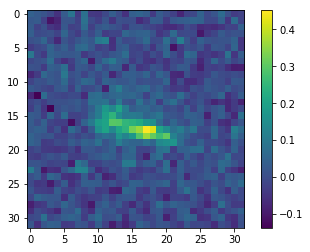

In [21]:
imshow(im[0,:,:,0]);colorbar()

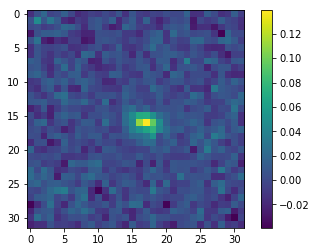

In [60]:
imshow(im[0,:,:,0]);colorbar()